Making PLs code to remove negative values work in MM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
t1data = Table.read('../trappist-1/combined/trappist-1_sed_var_res_v04.ecsv')


In [3]:
#from utils.py
def inranges(values, ranges, inclusive=[False, True]):
    """Determines whether values are in the supplied list of sorted ranges.

    Parameters
    ----------
    values : 1-D array-like
        The values to be checked.
    ranges : 1-D or 2-D array-like
        The ranges used to check whether values are in or out.
        If 2-D, ranges should have dimensions Nx2, where N is the number of
        ranges. If 1-D, it should have length 2N. A 2xN array may be used, but
        note that it will be assumed to be Nx2 if N == 2.
    inclusive : length 2 list of booleans
        Whether to treat bounds as inclusive. Because it is the default
        behavior of numpy.searchsorted, [False, True] is the default here as
        well. Using [False, False] or [True, True] will require roughly triple
        computation time.

    Returns a boolean array indexing the values that are in the ranges.
    """
    ranges = np.asarray(ranges)
    if ranges.ndim == 2:
        if ranges.shape[1] != 2:
            ranges = ranges.T
        ranges = ranges.ravel()

    if inclusive == [0, 1]:
        return (np.searchsorted(ranges, values) % 2 == 1)
    if inclusive == [1, 0]:
        return (np.searchsorted(ranges, values, side='right') % 2 == 1)
    if inclusive == [1, 1]:
        a = (np.searchsorted(ranges, values) % 2 == 1)
        b = (np.searchsorted(ranges, values, side='right') % 2 == 1)
        return (a | b)
    if inclusive == [0, 0]:
        a = (np.searchsorted(ranges, values) % 2 == 1)
        b = (np.searchsorted(ranges, values, side='right') % 2 == 1)
        return (a & b)

lyacut = (np.array([-400, 400])/3e5 + 1)*1215.67 #[1209.67,1221.67]
band_dv = 100 * u.km/u.s
line_centers = {'c2': [1334.532, 1335.708], 'si3': [1206.51], 'si4': [1393.76, 1402.77], 'n5': [1238.821, 1242.804],
                'c4': [1548.202, 1550.774], 'mg2':[2796.352, 2803.530],
                'he2':[1640.4], 'o1':[1302.17, 1304.86, 1306.03], 'al2':[1670.79],
                'c3':[1174.93, 1175.26, 1175.59, 1175.71, 1175.99, 1176.37], 'si2':[1808.00, 1816.92]}
def getbands(v0, v1, centers):
    fracs = u.Quantity([v0, v1])/const.c
    fracs = fracs.decompose().value
    centers = np.array(centers)
    bands = centers[:, np.newaxis] * (1 + fracs[np.newaxis, :])
    if len(bands) > 1:
        l, r = bands.T
        i_delete, = np.nonzero(r[:-1] >= l[1:])
        bands = np.array([np.delete(l, i_delete+1), np.delete(r, i_delete)]).T
    return bands

def line_band_maker():
    line_bands = {}
    for key in line_centers:
        line_bands[key] = getbands(-band_dv, band_dv, line_centers[key])
    line_bands['lya'] = [lyacut]
    return line_bands


def killnegatives(spectbl, sep_insts=False, quickndirty=False, minSN=None, res_limit=1.0):
    """
    Removes negative bins by summing with adjacent bins until there are no negative bins left. I.e. the resolution in
    negative areas is degraded until the flux is no longer negative.

    Parameters
    ----------
    spectbl

    Returns
    -------
    newtbl
        A new bare-bones spectbl that has bin edges, flux, and error
        WARNING: the obs date, instrument, etc. columns will all get set to default values, as will all of the
        metadata except for 'star'
    """
    if not np.any(spectbl['FLUX'] < 0):
        return spectbl

  #  if sep_insts:
   #     return inst_by_inst(spectbl, killnegatives, sep_insts=False, quickndirty=quickndirty, minSN=minSN)

 #   if hasgaps(spectbl):
  #      return gap_by_gap(spectbl, killnegatives, sep_insts=False, quickndirty=quickndirty, minSN=minSN)

    w0, w1, f_dsty, e_dsty = [spectbl[s].copy() for s in ['WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR']]
    line_bands = line_band_maker()
    line_bands = np.vstack(line_bands.values())
    line_bands = line_bands[np.argsort(line_bands[:,0]), :]
    untouchable = inranges(w0, line_bands) | inranges(w1, line_bands)
    if minSN is None:
        untouchable = untouchable & (f_dsty >= 0)
    else:
        untouchable = untouchable & (f_dsty/e_dsty >= minSN)
    dw = w1 - w0
    f, e = f_dsty*dw, e_dsty*dw
    v = e**2

    # I had this kind of vectorized once, but ultimately I think it just made for terrible readability with little gain in speed
    # print "bad bins remaining:"
    while True:
        if minSN is None:
            n = np.sum(f < 0)
        else:
            n = np.sum(f / np.sqrt(v) < minSN)
        # print n
        if n == 0:
            break

        # find the worst offending point
        imin = np.argmin(f/np.sqrt(v)) if minSN else np.argmin(f)

        # integrate bins progressively outward until it no longer offends
        i0, i1 = imin-1, imin+1
        w0bin, w1bin, fbin, vbin = w0[imin], w1[imin], f[imin], v[imin]
        side = 0
        while True:
            if minSN is None:
                if fbin >= 0:
                    break
            else:
                if fbin/sqrt(vbin) >= minSN:
                    break

            # check if we should stop integrating outward on either side
            stop_at_0 = i0 < 0 or untouchable[i0]
            stop_at_1 = i1 > len(f)-1 or untouchable[i1]

            # if can't integrate further outward, then set fbin to 0 if it is still negative and break
            if stop_at_0 and stop_at_1:
                if fbin < 0:
                    fbin, vbin = 0, 0
                break

            # else incorporate the next bin
            if side == 0 and not stop_at_0:
                fbin += f[i0]
                vbin += v[i0]
                i0 -= 1
            elif not stop_at_1:
                fbin += f[i1]
                vbin += v[i1]
                i1 += 1

            # switch sides if possible
            if stop_at_0:
                side = 1
            elif stop_at_1:
                side = 0
            else:
                side = not side

        # replace the appropriate section of the vectors
        bad_block = slice(i0+1, i1)
        arrays = w0, w1, f, v, untouchable
        wrng = w1[i1-1] - w0[i0+1]
        if wrng > res_limit:
            w0in = np.arange(w0[i0+1], w1[i1-1], res_limit)
            w1in = np.append(w0in[1:], w1[i1-1])
            dw = w1in - w0in
            fin = fbin*dw/wrng
            vin = vbin*dw/wrng
            inserts = w0in, w1in, fin, vin, [False]*len(fin)
        else:
            inserts = w0[i0+1], w1[i1-1], fbin, vbin, False
        new_arrays = []
        for a, value in zip(arrays, inserts):
            a = np.delete(a, bad_block)
            a = np.insert(a, i0+1, value)
            new_arrays.append(a)
        w0, w1, f, v, untouchable = new_arrays

    # return a spectbl
    dw = w1 - w0
    f_dsty, e_dsty = f / dw, np.sqrt(v) / dw
    bins = np.array([w0, w1]).T
    #print(np.mean(bins, axis=1))
    #newspec = rebin(spectbl, bins)
    #newspec = spectbl
    #newspec['FLUX'] = f_dsty * newspec['FLUX'].unit
    #newspec['ERROR'] = e_dsty * newspec['ERROR'].unit
    w_dsty = np.mean(bins, axis=1)
    return w_dsty, f_dsty, e_dsty


In [4]:
#w1, f1, e1 = killnegatives(t1data)

In [5]:
len(t1data['WAVELENGTH'])

1202472

In [6]:
#plt.step(t1data['WAVELENGTH'], t1data['FLUX'])
#plt.step(w1, f1, where='mid')
#plt.yscale('log')
#plt.xscale('log')

In [7]:
#gjdata = Table.read('../gj_674/combined/gj_674_sed_var_res_v3.ecsv')

In [8]:
#w2, f2, e2 = killnegatives(gjdata)

In [9]:
#plt.step(w2, f2, where='mid')
#plt.yscale('log')
#plt.xscale('log')

This isn't working. Can I do it with smoothing?

In [10]:
from astropy.convolution import convolve, Box1DKernel


In [11]:
w, f, e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [12]:
 #nf = convolve(nf,Box1DKernel(smooth))
#ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5

smooth = 3
w1, f1, e1 = w, f, e
while np.sum(f1<0) > 0:
    sf = convolve(f,Box1DKernel(smooth))
    se = convolve(e,Box1DKernel(smooth))/smooth**0.5
    for i, fi in enumerate(f1):
        if fi < 0:
            f1[i], e1[i] = sf[i], se[i]
    smooth += 2
print(smooth)
        
    

105


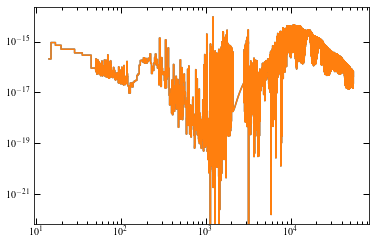

In [13]:
plt.step(t1data['WAVELENGTH'], t1data['FLUX'], where='mid')
plt.step(w1,f1, where='mid')
plt.yscale('log')
plt.xscale('log')